<a href="https://colab.research.google.com/github/Aryathama/10/blob/main/TSP%20ATM%20BCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation**

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_excel('Dataset SC ATM BCA.xlsx')

In [ ]:
# Konversi Longitude dan Latitude ke desimal derajat (jika perlu dibagi 1e6)
df['Longitude'] = df['Longitude'] / 1e6
df['Latitude'] = df['Latitude'] / 1e6

# Ambil fitur lokasi
locations = df[['Longitude', 'Latitude']]

# Standarisasi data
scaler = StandardScaler()
locations_scaled = scaler.fit_transform(locations)

# **Clustered**

**Elbow Method**

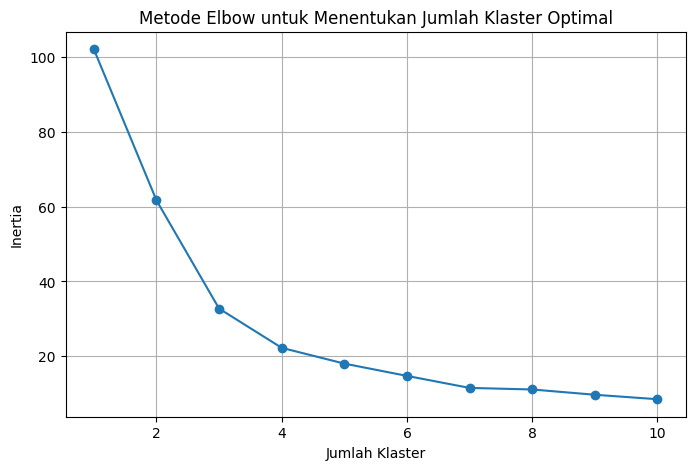

In [ ]:
# Metode Elbow untuk menentukan jumlah klaster optimal
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(locations_scaled)
    inertia.append(kmeans.inertia_)

# Visualisasi Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Metode Elbow untuk Menentukan Jumlah Klaster Optimal')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

**Visualisasi Kluster**

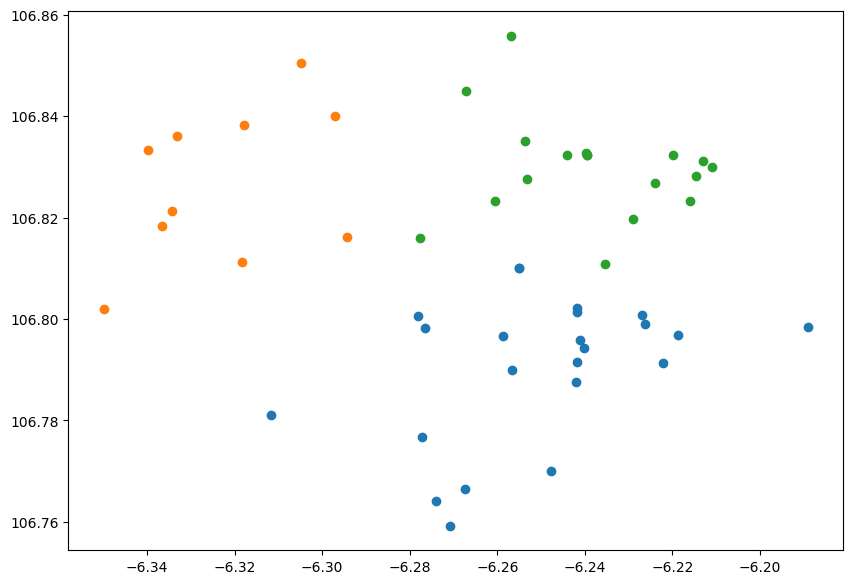

In [ ]:
# Setelah menentukan jumlah klaster terbaik (misal k=3)
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(locations_scaled)

# Visualisasi hasil klasterisasi
plt.figure(figsize=(10, 7))
for cluster_id in range(k_optimal):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], label=f'Klaster {cluster_id}')

**Haversine**

In [ ]:
import numpy as np
import random

def haversine(lon1, lat1, lon2, lat2):
    R = 6371
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def route_distance(route, coords):
    total = 0
    for i in range(len(route) - 1):
        total += haversine(*coords[route[i]], *coords[route[i+1]])
    # Tambahkan jarak dari titik terakhir kembali ke titik awal
    total += haversine(*coords[route[-1]], *coords[route[0]])
    return total

**Genetic Algorithm**

In [ ]:
import numpy as np
import random

def create_route(n):
    route = list(range(n))
    random.shuffle(route)
    return route

def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [None]*len(parent1)
    child[start:end] = parent1[start:end]
    pointer = 0
    for city in parent2:
        if city not in child:
            while child[pointer] is not None:
                pointer += 1
            child[pointer] = city
    return child

def mutate(route, mutation_rate=0.01):
    for i in range(len(route)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(route)-1)
            route[i], route[j] = route[j], route[i]
    return route

def genetic_algorithm(coords, population_size=150, generations=300):
    population = [create_route(len(coords)) for _ in range(population_size)]

    for gen in range(generations):
        population.sort(key=lambda r: route_distance(r, coords))
        next_gen = population[:10]  # elitism

        while len(next_gen) < population_size:
            parent1, parent2 = random.choices(population[:50], k=2)
            child = crossover(parent1, parent2)
            mutate(child)
            next_gen.append(child)

        population = next_gen

    best_route = min(population, key=lambda r: route_distance(r, coords))
    return best_route, route_distance(best_route, coords)


**Grid Search untuk Tuning GA (Tidak Perlu di Run!)**

In [ ]:
cluster_ids = sorted(df['Cluster'].unique())
best_result = None
best_config = None

for pop_size in [50, 100, 150]:
    for gen in [100, 200, 300]:
        for mut_rate in [0.01, 0.02, 0.05]:
            total_distance = 0
            for cluster_id in cluster_ids:
                coords = df[df['Cluster'] == cluster_id][['Longitude', 'Latitude']].to_numpy()
                cluster_coords = cluster_data[['Longitude', 'Latitude']].values

                # Jalankan GA dengan konfigurasi saat ini
                def ga_with_custom_mutation(coords, pop_size, gens, mut_rate):
                    population = [create_route(len(coords)) for _ in range(pop_size)]
                    for g in range(gens):
                        population.sort(key=lambda r: route_distance(r, coords))
                        next_gen = population[:10]
                        while len(next_gen) < pop_size:
                            p1, p2 = random.choices(population[:50], k=2)
                            child = crossover(p1, p2)
                            mutate(child, mutation_rate=mut_rate)
                            next_gen.append(child)
                        population = next_gen
                    best = min(population, key=lambda r: route_distance(r, coords))
                    return best, route_distance(best, coords)

                best_route, best_distance = ga_with_custom_mutation(cluster_coords, pop_size, gen, mut_rate)
                total_distance += best_distance

            print(f"Tested pop={pop_size}, gen={gen}, mut={mut_rate} → Total distance: {total_distance:.2f} km")

            if best_result is None or total_distance < best_result:
                best_result = total_distance
                best_config = (pop_size, gen, mut_rate)

print("\n=== Best Overall Configuration Across All Clusters ===")
print(f"Population Size: {best_config[0]}")
print(f"Generations: {best_config[1]}")
print(f"Mutation Rate: {best_config[2]}")
print(f"Total Distance (All Clusters): {best_result:.2f} km")


Tested pop=50, gen=100, mut=0.01 → Total distance: 43.71 km


KeyboardInterrupt: 

**Algoritma NN + 2-Opt**

In [ ]:
def best_nn_two_opt(coords):
    best_path = None
    best_dist = float('inf')

    for start in range(len(coords)):
        path = nearest_neighbor_with_start(coords, start)
        path = two_opt_limited(path, coords)
        dist = route_distance(path, coords)

        if dist < best_dist:
            best_path = path
            best_dist = dist

    return best_path, best_dist

def nearest_neighbor_with_start(coords, start):
    n = len(coords)
    visited = [False]*n
    path = [start]
    visited[start] = True
    for _ in range(n - 1):
        last = path[-1]
        next_idx = min(
            [(i, haversine(*coords[last], *coords[i])) for i in range(n) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        path.append(next_idx)
        visited[next_idx] = True
    return path

def two_opt_limited(path, coords, max_iter=200):
    best = path
    improved = True
    count = 0
    while improved and count < max_iter:
        improved = False
        for i in range(1, len(path) - 2):
            for j in range(i + 1, len(path)):
                if j - i == 1:
                    continue
                new_path = best[:i] + best[i:j][::-1] + best[j:]
                if route_distance(new_path, coords) < route_distance(best, coords):
                    best = new_path
                    improved = True
        path = best
        count += 1
    return best


**Perbandingan GA dan NN + 2-Opt**

Jarak untuk Klaster 0 (GA): 18.49 km
Jarak untuk Klaster 1 (GA): 12.13 km
Jarak untuk Klaster 2 (GA): 12.63 km


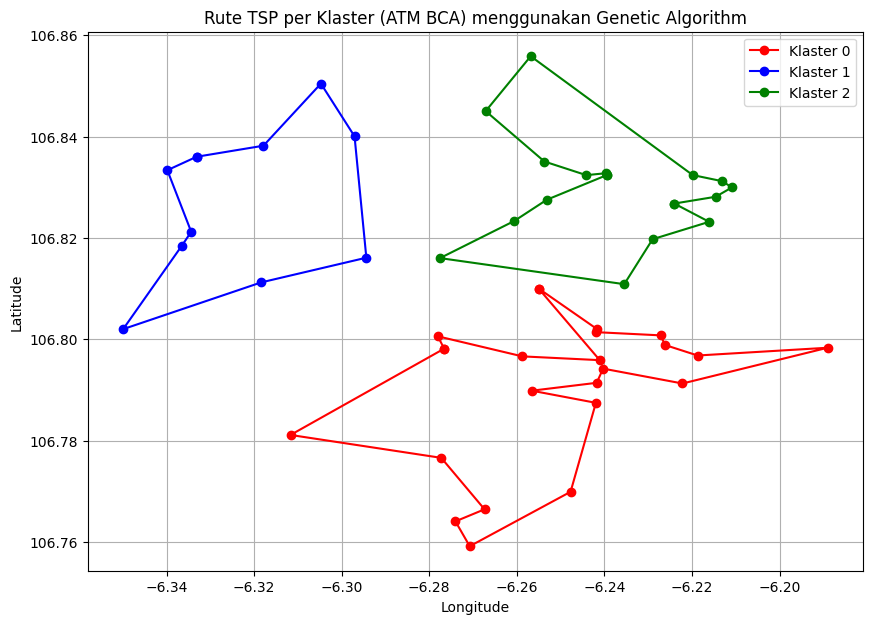

Jarak untuk Klaster 0 (NN + 2-Opt): 18.11 km
Jarak untuk Klaster 1 (NN + 2-Opt): 12.13 km
Jarak untuk Klaster 2 (NN + 2-Opt): 12.63 km


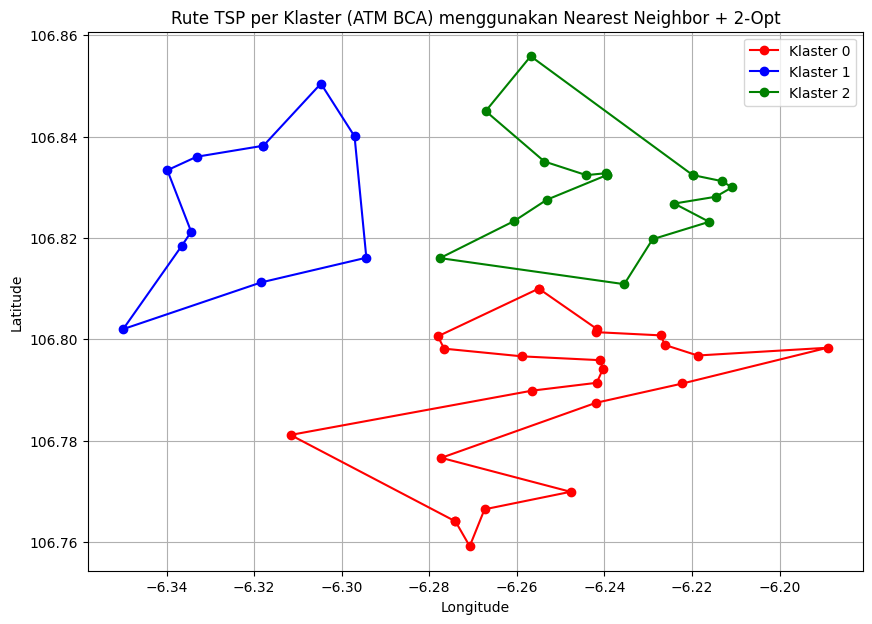

In [ ]:
import numpy as np

colors = ['red', 'blue', 'green']
plt.figure(figsize=(10, 7))

for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    cluster_coords = cluster_data[['Longitude', 'Latitude']].values
    best_route, _ = genetic_algorithm(cluster_coords)

    # Urutan koordinat tanpa loop
    ordered_coords = cluster_coords[best_route]
    # Tambah titik awal di akhir supaya loop tertutup
    ordered_coords_loop = np.vstack([ordered_coords, ordered_coords[0]])

    # Hitung jarak untuk kluster ini
    cluster_distance = route_distance(best_route, cluster_coords)
    print(f"Jarak untuk Klaster {i} (GA): {cluster_distance:.2f} km")

    plt.plot(ordered_coords_loop[:, 0], ordered_coords_loop[:, 1],
             marker='o', color=colors[i], label=f'Klaster {i}')

plt.title("Rute TSP per Klaster (ATM BCA) menggunakan Genetic Algorithm")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

# dan untuk NN + 2-Opt:
plt.figure(figsize=(10, 7))

for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    cluster_coords = cluster_data[['Longitude', 'Latitude']].values
    best_route, _ = best_nn_two_opt(cluster_coords)

    ordered_coords = cluster_coords[best_route]
    ordered_coords_loop = np.vstack([ordered_coords, ordered_coords[0]])

    # Hitung jarak untuk kluster ini
    cluster_distance = route_distance(best_route, cluster_coords)
    print(f"Jarak untuk Klaster {i} (NN + 2-Opt): {cluster_distance:.2f} km")

    plt.plot(ordered_coords_loop[:, 0], ordered_coords_loop[:, 1],
             marker='o', color=colors[i], label=f'Klaster {i}')

plt.title("Rute TSP per Klaster (ATM BCA) menggunakan Nearest Neighbor + 2-Opt")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


# **Modified Clustered**

In [ ]:
import numpy as np
import random

def create_route(n, start_idx=None):
    route = list(range(n))

    if start_idx is not None:
        route.remove(start_idx)
        random.shuffle(route)
        return [start_idx] + route
    else:
        random.shuffle(route)
        return route

def crossover(parent1, parent2, start_idx=None):
    size = len(parent1)
    child = [None] * size

    # Opsi: pakai posisi 0 sebagai fixed start
    if start_idx is not None:
        child[0] = start_idx

    pointer = 1 if start_idx is not None else 0

    for city in parent2:
        if start_idx is not None and city == start_idx:
            continue
        if city not in child:
            # Tambahkan proteksi batas
            while pointer < size and child[pointer] is not None:
                pointer += 1
            if pointer < size:
                child[pointer] = city
            else:
                break  # Hindari IndexError
    return child

def mutate(route, mutation_rate=0.01):
    for i in range(1, len(route)):  # mulai dari 1, supaya index 0 tidak disentuh
        if random.random() < mutation_rate:
            j = random.randint(1, len(route)-1)
            route[i], route[j] = route[j], route[i]
    return route

def ga_clustered_fixed(coords, population_size=150, generations=300, start_idx=None):
    population = [create_route(len(coords), start_idx=start_idx) for _ in range(population_size)]

    for gen in range(generations):
        population.sort(key=lambda r: route_distance(r, coords))
        next_gen = population[:10]  # elitism

        while len(next_gen) < population_size:
            parent1, parent2 = random.choices(population[:50], k=2)
            child = crossover(parent1, parent2)
            mutate(child)
            next_gen.append(child)

        population = next_gen

    best_route = min(population, key=lambda r: route_distance(r, coords))
    return best_route, route_distance(best_route, coords)


In [ ]:
def nn_two_opt_cf(coords, start_idx=None):
    path = nearest_neighbor_with_start(coords, start_idx)
    path = two_opt_limited(path, coords)
    dist = route_distance(path, coords)
    return path, dist


def nearest_neighbor_with_start(coords, start):
    n = len(coords)
    visited = [False]*n
    path = [start]
    visited[start] = True
    for _ in range(n - 1):
        last = path[-1]
        next_idx = min(
            [(i, haversine(*coords[last], *coords[i])) for i in range(n) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        path.append(next_idx)
        visited[next_idx] = True
    return path

def two_opt_limited(path, coords, max_iter=200):
    best = path
    improved = True
    count = 0
    while improved and count < max_iter:
        improved = False
        for i in range(1, len(path) - 2):
            for j in range(i + 1, len(path)):
                if j - i == 1:
                    continue
                new_path = best[:i] + best[i:j][::-1] + best[j:]
                if route_distance(new_path, coords) < route_distance(best, coords):
                    best = new_path
                    improved = True
        path = best
        count += 1
    return best

Jarak untuk Klaster 0 (GA): 18.71 km
Jarak untuk Klaster 1 (GA): 20.70 km
Jarak untuk Klaster 2 (GA): 17.77 km


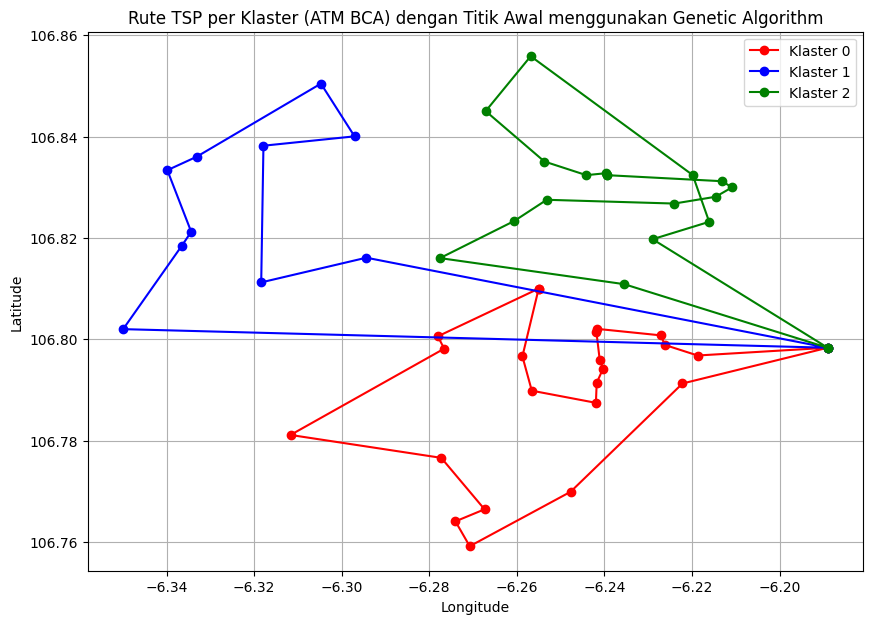

In [ ]:
colors = ['red', 'blue', 'green']
plt.figure(figsize=(10, 7))

fixed_index_global = 50            # baris global ke-50
fixed_coord = df.iloc[fixed_index_global][['Longitude','Latitude']].values

for i in range(3):
    cluster_data   = df[df['Cluster'] == i]          # subset
    cluster_coords = cluster_data[['Longitude','Latitude']].values

    # Cek apakah titik ke-50 ada di dalam cluster
    if fixed_index_global in cluster_data.index:
        # Kalau sudah ada, langsung gunakan
        found_idx = cluster_data.index.get_loc(fixed_index_global)
    else:
        # Kalau tidak ada, tambahkan titik ke-50 ke cluster_coords
        cluster_coords = np.vstack([cluster_coords, fixed_coord])
        found_idx = len(cluster_coords) - 1  # Titik ke-50 menjadi titik terakhir di koordinat

    # Pastikan titik ke-50 berada di awal rute
    ga_path_cf, _ = ga_clustered_fixed(cluster_coords, start_idx=found_idx)

    # Visualisasi dan hitung jarak
    ordered_coords = cluster_coords[ga_path_cf]
    ordered_coords_loop = np.vstack([ordered_coords, ordered_coords[0]])

    # Hitung jarak untuk kluster ini
    cluster_distance = route_distance(ga_path_cf, cluster_coords)
    print(f"Jarak untuk Klaster {i} (GA): {cluster_distance:.2f} km")

    # Plot untuk visualisasi
    plt.plot(ordered_coords_loop[:, 0], ordered_coords_loop[:, 1],
             marker='o', color=colors[i], label=f'Klaster {i}')

plt.title("Rute TSP per Klaster (ATM BCA) dengan Titik Awal menggunakan Genetic Algorithm")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Final fix: ensure all coordinates are in [latitude, longitude] and that depot + clusters are consistent

# Load ulang data agar sinkron
df = pd.read_excel("Dataset SC ATM BCA.xlsx")
df['Lat'] = df['Longitude'] / 1e6
df['Lon'] = df['Latitude'] / 1e6

# KMeans clustering
coords = df[['Lat', 'Lon']].values
scaled_coords = StandardScaler().fit_transform(coords)
df['Cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(scaled_coords)

# Titik depot (baris ke-50)
fixed_index_global = 50
fixed_coord = df.iloc[fixed_index_global][['Lat', 'Lon']].values
depot_latlon = fixed_coord.tolist()

# Peta baru
m = folium.Map(location=depot_latlon, zoom_start=12)

# Tambahkan marker untuk depot
folium.Marker(
    location=depot_latlon,
    popup="Depot (Index 50)",
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

colors = ['red', 'blue', 'green']

# Loop tiap klaster
for i in range(3):
    cluster_data = df[df['Cluster'] == i]
    cluster_coords = cluster_data[['Lon', 'Lat']].values  # untuk distance: lon-lat

    # tambahkan depot jika belum ada
    if fixed_index_global in cluster_data.index:
        start_idx = cluster_data.index.get_loc(fixed_index_global)
    else:
        cluster_coords = np.vstack([cluster_coords, fixed_coord[::-1]])  # lon-lat
        start_idx = len(cluster_coords) - 1

    # GA run
    ga_path, dist = ga_clustered_fixed(cluster_coords, start_idx=start_idx)

    # pastikan pulang ke depot
    if ga_path[-1] != start_idx:
        ga_path.append(start_idx)

    # konversi ke latlon untuk folium
    ordered_coords = cluster_coords[ga_path]
    latlon_coords = [[lat, lon] for lon, lat in ordered_coords]

    # tambahkan polyline
    folium.PolyLine(
        locations=latlon_coords,
        color=colors[i],
        weight=4,
        tooltip=f"Klaster {i} - Jarak: {dist:.2f} km"
    ).add_to(m)

    # tambahkan titik-titik
    for lat, lon in latlon_coords:
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=colors[i],
            fill=True,
            fill_opacity=0.8
        ).add_to(m)

# Simpan file final
m

Jarak untuk Klaster 0 (NN + 2-Opt): 19.33 km
Jarak untuk Klaster 1 (NN + 2-Opt): 19.95 km
Jarak untuk Klaster 2 (NN + 2-Opt): 19.46 km


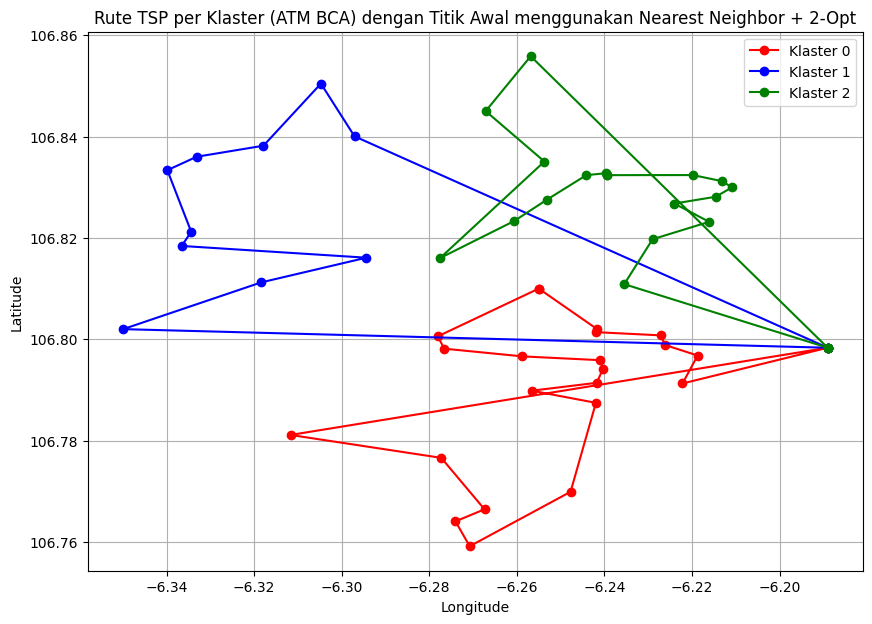

In [ ]:
colors = ['red', 'blue', 'green']
plt.figure(figsize=(10, 7))

fixed_index_global = 50            # baris global ke-50
fixed_coord = df.iloc[fixed_index_global][['Longitude','Latitude']].values

for i in range(3):
    cluster_data   = df[df['Cluster'] == i]          # subset
    cluster_coords = cluster_data[['Longitude','Latitude']].values

    # Cek apakah titik ke-50 ada di dalam cluster
    if fixed_index_global in cluster_data.index:
        # Kalau sudah ada, langsung gunakan
        found_idx = cluster_data.index.get_loc(fixed_index_global)
    else:
        # Kalau tidak ada, tambahkan titik ke-50 ke cluster_coords
        cluster_coords = np.vstack([cluster_coords, fixed_coord])
        found_idx = len(cluster_coords) - 1  # Titik ke-50 menjadi titik terakhir di koordinat

    # Pastikan titik ke-50 berada di awal rute
    nn_opt_path_cf, _ = nn_two_opt_cf(cluster_coords, start_idx=found_idx)

    # Visualisasi dan hitung jarak
    ordered_coords = cluster_coords[nn_opt_path_cf]
    ordered_coords_loop = np.vstack([ordered_coords, ordered_coords[0]])

    # Hitung jarak untuk kluster ini
    cluster_distance = route_distance(nn_opt_path_cf, cluster_coords)
    print(f"Jarak untuk Klaster {i} (NN + 2-Opt): {cluster_distance:.2f} km")

    plt.plot(ordered_coords_loop[:, 0], ordered_coords_loop[:, 1],
             marker='o', color=colors[i], label=f'Klaster {i}')

plt.title("Rute TSP per Klaster (ATM BCA) dengan Titik Awal menggunakan Nearest Neighbor + 2-Opt")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Lanjutkan proses membangun peta setelah fungsi NN+2Opt sudah tersedia

# Siapkan ulang titik depot
fixed_latlon = df.iloc[fixed_index_global][['Lat', 'Lon']].values.tolist()
fixed_lonlat = df.iloc[fixed_index_global][['Lon', 'Lat']].values.tolist()

# Siapkan folium map
m = folium.Map(location=fixed_latlon, zoom_start=12)
folium.Marker(
    location=fixed_latlon,
    icon=folium.Icon(color='red', icon='home'),
    popup='Depot (Titik Awal & Akhir - Index 50)'
).add_to(m)

# Warna untuk masing-masing klaster
color_map = ['red', 'blue', 'green']

# Plotkan untuk setiap klaster
for i in range(3):
    cluster_data = df[df['Cluster'] == i].copy()
    coords_lonlat = cluster_data[['Lon', 'Lat']].values.tolist()
    coords_latlon = cluster_data[['Lat', 'Lon']].values.tolist()

    if fixed_index_global in cluster_data.index:
        start_idx = cluster_data.index.get_loc(fixed_index_global)
    else:
        coords_lonlat.append(fixed_lonlat)
        coords_latlon.append(fixed_latlon)

    # Dapatkan rute NN+2Opt
    path, dist = best_nn_two_opt(np.array(coords_lonlat))
    path.append(path[0])  # pastikan kembali ke titik awal

    ordered_latlon = [coords_latlon[idx] for idx in path]

    # Gambar rute
    folium.PolyLine(locations=ordered_latlon,
                    color=color_map[i],
                    weight=4,
                    tooltip=f"Rute Klaster {i} (Best NN+2Opt) - Jarak: {dist:.2f} km").add_to(m)

    # Gambar titik
    for lat, lon in ordered_latlon:
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color=color_map[i],
            fill=True,
            fill_opacity=0.8
        ).add_to(m)

# Simpan peta hasil
m


# **Non Clustered**

**GA Fixed Start (Mutation Rate: 0.02)**

In [ ]:
def create_route_fixed(n, start_index):
    remaining = list(range(n))
    remaining.remove(start_index)
    random.shuffle(remaining)
    return [start_index] + remaining

def crossover_fixed(parent1, parent2, start_index):
    start, end = sorted(random.sample(range(1, len(parent1)), 2))  # skip index 0
    child = [None] * len(parent1)
    child[0] = start_index
    child[start:end] = parent1[start:end]
    pointer = 1
    for city in parent2:
        if city not in child:
            while child[pointer] is not None:
                pointer += 1
            child[pointer] = city
    return child

def mutate_fixed(route, mutation_rate=0.02):
    for i in range(1, len(route)):  # skip index 0
        if random.random() < mutation_rate:
            j = random.randint(1, len(route) - 1)  # skip index 0
            route[i], route[j] = route[j], route[i]
    return route

def genetic_algorithm_fixed_start(coords, start_index=0, population_size=150, generations=300):
    n = len(coords)
    population = [create_route_fixed(n, start_index) for _ in range(population_size)]

    for gen in range(generations):
        population.sort(key=lambda r: route_distance(r, coords))
        next_gen = population[:10]  # elitism

        while len(next_gen) < population_size:
            parent1, parent2 = random.choices(population[:50], k=2)
            child = crossover_fixed(parent1, parent2, start_index)
            mutate_fixed(child)
            next_gen.append(child)

        population = next_gen

    best_route = min(population, key=lambda r: route_distance(r, coords))
    return best_route, route_distance(best_route, coords)

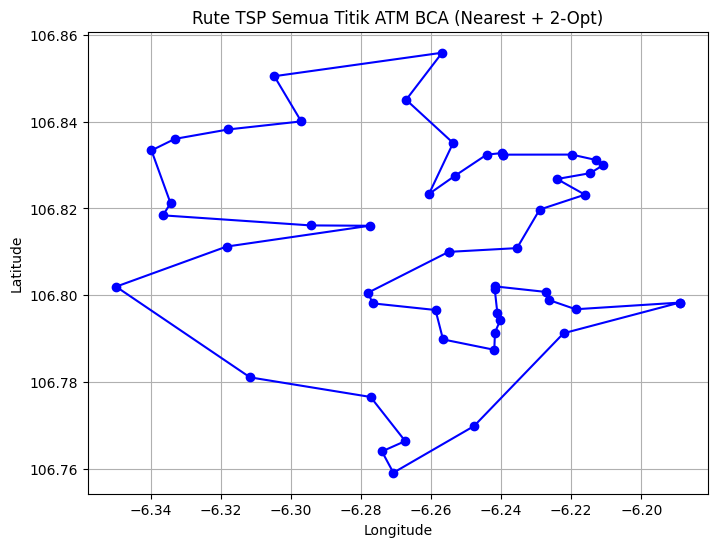

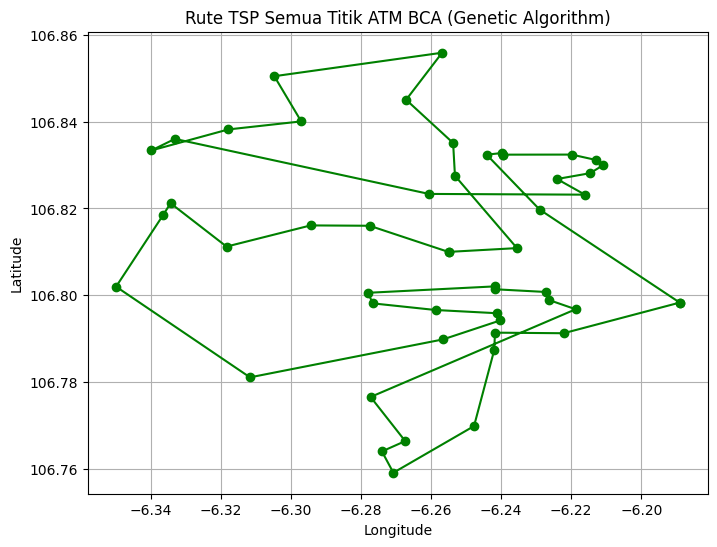

🧭 Total jarak (Nearest + 2-Opt): 38.54 km
🧬 Total jarak (Genetic Algorithm): 47.19 km

✅ Hasil disimpan ke file: TSP_NonClustered_Result_ATM_BCA.xlsx


In [ ]:
# Ambil semua koordinat
coords = df[['Longitude', 'Latitude']].to_numpy()

# Cek jumlah titik cukup
fixed_start = 50

if len(coords) < 2:
    print("Dataset hanya punya 1 titik, tidak bisa dihitung rute.")
else:
    # Jalankan Nearest Neighbor dari titik awal tetap
    path = nearest_neighbor_with_start(coords, fixed_start)
    nn_opt_path = two_opt_limited(path, coords, max_iter=200)
    nn_dist = route_distance(nn_opt_path + [nn_opt_path[0]], coords)

    # Genetic Algorithm
    ga_path, ga_dist = genetic_algorithm_fixed_start(coords, start_index=fixed_start)

    # Buat kolom urutan TSP
    df['TSP_Order_NN'] = [None]*len(df)
    for order, idx in enumerate(nn_opt_path):
        df.at[idx, 'TSP_Order_NN'] = order

    df['TSP_Order_GA'] = [None]*len(df)
    for order, idx in enumerate(ga_path):
        df.at[idx, 'TSP_Order_GA'] = order

    # Visualisasi
    ordered_coords_nn = np.vstack([coords[nn_opt_path], coords[nn_opt_path[0]]])
    ordered_coords_ga = np.vstack([coords[ga_path], coords[ga_path[0]]])

    # Plot Nearest Neighbor + 2-Opt
    plt.figure(figsize=(8, 6))
    plt.plot(ordered_coords_nn[:, 0], ordered_coords_nn[:, 1], marker='o', color='blue')
    plt.title(f'Rute TSP Semua Titik ATM BCA (Nearest + 2-Opt)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Plot Genetic Algorithm
    plt.figure(figsize=(8, 6))
    plt.plot(ordered_coords_ga[:, 0], ordered_coords_ga[:, 1], marker='o', color='green')
    plt.title(f'Rute TSP Semua Titik ATM BCA (Genetic Algorithm)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    print(f"🧭 Total jarak (Nearest + 2-Opt): {nn_dist:.2f} km")
    print(f"🧬 Total jarak (Genetic Algorithm): {ga_dist:.2f} km")


In [ ]:
import folium
from folium.plugins import MarkerCluster

ordered_coords_nn = [(lat, lon) for lon, lat in coords[nn_opt_path]]

start_lat, start_lon = ordered_coords_nn[0][1], ordered_coords_nn[0][0]
m = folium.Map(location=[start_lat, start_lon], zoom_start=13)

folium.PolyLine(
    locations=[(lat, lon) for lon, lat in ordered_coords_nn] + [(start_lat, start_lon)],  # balik ke titik awal
    color='blue',
    weight=4,
    opacity=0.7
).add_to(m)

for i, (lon, lat) in enumerate(ordered_coords_nn):
    folium.Marker(
        location=(lat, lon),
        popup=f"Titik {i}",
        icon=folium.Icon(color='red' if i == 0 else 'blue', icon='info-sign')
    ).add_to(m)

m

In [ ]:
import pandas as pd

df = pd.read_excel('Dataset SC ATM BCA.xlsx')

ordered_coords_nn = [(df.iloc[i]['Longitude'], df.iloc[i]['Latitude'], df.iloc[i]['Nama ATM BCA']) for i in nn_opt_path]

route_info = []
for i in range(len(ordered_coords_nn) - 1):
    current_location = ordered_coords_nn[i][2]  # Nama lokasi titik saat ini
    next_location = ordered_coords_nn[i + 1][2]  # Nama lokasi titik berikutnya
    route_info.append(f"{current_location} -> {next_location}")

start_location = ordered_coords_nn[0][2]  # Nama lokasi titik awal
end_location = ordered_coords_nn[-1][2]  # Nama lokasi titik terakhir
route_info.append(f"{end_location} -> {start_location}")

for step in route_info:
    print(step)

BCA KCU WISMA ASIA -> 087U -Ruko Patal Senayan 1
087U -Ruko Patal Senayan 1 -> 0580 - Senayan Plaza 1
0580 - Senayan Plaza 1 -> 067Y - Ratu Plaza 3 
067Y - Ratu Plaza 3  -> 101J -Hassanudin
101J -Hassanudin -> 067Z - A Mart Cafe, Resto & Mart
067Z - A Mart Cafe, Resto & Mart -> 058A - Circle K JAK0354 Bulungan
058A - Circle K JAK0354 Bulungan -> 078U - Circle K JAK0368 Kyai Maja 
078U - Circle K JAK0368 Kyai Maja  -> 0648 - Mayestik 2
0648 - Mayestik 2 -> 102E - Circle K CK0343 -New Gandaria 
102E - Circle K CK0343 -New Gandaria  -> 050V - Radio Dalam 3
050V - Radio Dalam 3 -> 052J - SPBU 34-12401 Fatmawati Raya
052J - SPBU 34-12401 Fatmawati Raya -> 0663 - BSI Fatmaawati
0663 - BSI Fatmaawati -> 067N - Lawson Cipete Raya 
067N - Lawson Cipete Raya  -> 0555 - Kemang Mansion 2
0555 - Kemang Mansion 2 -> 0905 -Kemang Mansion 1
0905 -Kemang Mansion 1 -> 057Z - Circle K JAK0306 Ciniru
057Z - Circle K JAK0306 Ciniru -> 0542 - Argo Manunggal
0542 - Argo Manunggal -> 052Q - Indomaret Karbela


In [ ]:
import folium
from folium.plugins import MarkerCluster

ordered_coords_ga = [(lat, lon) for lon, lat in coords[ga_path]]

start_lat, start_lon = ordered_coords_ga[0][1], ordered_coords_ga[0][0]
m = folium.Map(location=[start_lat, start_lon], zoom_start=13)

folium.PolyLine(
    locations=[(lat, lon) for lon, lat in ordered_coords_ga] + [(start_lat, start_lon)],  # balik ke titik awal
    color='blue',
    weight=4,
    opacity=0.7
).add_to(m)

for i, (lon, lat) in enumerate(ordered_coords_ga):
    folium.Marker(
        location=(lat, lon),
        popup=f"Titik {i}",
        icon=folium.Icon(color='red' if i == 0 else 'blue', icon='info-sign')
    ).add_to(m)

m

In [ ]:
import pandas as pd

df = pd.read_excel('Dataset SC ATM BCA.xlsx')

ordered_coords_ga = [(df.iloc[i]['Longitude'], df.iloc[i]['Latitude'], df.iloc[i]['Nama ATM BCA']) for i in ga_path]

route_info = []
for i in range(len(ordered_coords_ga) - 1):
    current_location = ordered_coords_ga[i][2]  # Nama lokasi titik saat ini
    next_location = ordered_coords_ga[i + 1][2]  # Nama lokasi titik berikutnya
    route_info.append(f"{current_location} -> {next_location}")

start_location = ordered_coords_ga[0][2]  # Nama lokasi titik awal
end_location = ordered_coords_ga[-1][2]  # Nama lokasi titik terakhir
route_info.append(f"{end_location} -> {start_location}")

for step in route_info:
    print(step)


BCA KCU WISMA ASIA -> 087X - Ruko Patal Senayan 2
087X - Ruko Patal Senayan 2 -> 0648 - Mayestik 2
0648 - Mayestik 2 -> 102E - Circle K CK0343 -New Gandaria 
102E - Circle K CK0343 -New Gandaria  -> 057C - Alfamidi Delman
057C - Alfamidi Delman -> 055A - Circle K JAK0334 Kesehatan Bintaro
055A - Circle K JAK0334 Kesehatan Bintaro -> 054Z - Circle K JAK0333 RC Veteran Bintaro
054Z - Circle K JAK0333 RC Veteran Bintaro -> 0933 -RS.Dr>Sutoyo
0933 -RS.Dr>Sutoyo -> 063H - Alfamart Pondok Indah I
063H - Alfamart Pondok Indah I -> 087U -Ruko Patal Senayan 1
087U -Ruko Patal Senayan 1 -> 0580 - Senayan Plaza 1
0580 - Senayan Plaza 1 -> 067Y - Ratu Plaza 3 
067Y - Ratu Plaza 3  -> 067Z - A Mart Cafe, Resto & Mart
067Z - A Mart Cafe, Resto & Mart -> 101J -Hassanudin
101J -Hassanudin -> 067N - Lawson Cipete Raya 
067N - Lawson Cipete Raya  -> 0663 - BSI Fatmaawati
0663 - BSI Fatmaawati -> 052J - SPBU 34-12401 Fatmawati Raya
052J - SPBU 34-12401 Fatmawati Raya -> 058A - Circle K JAK0354 Bulungan
0